## VAE Example

This notebook demonstrates how to build a Variational Autoencoder (VAE) [1]. We will train a VAE to generate images of handwritten digits (0-9). The VAE will be built in CNN PyTorch and trained on the MNIST dataset [2].

References:
- [1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [2] LeCun, Yann, and Corinna Cortes. "MNIST handwritten digit database." (2010).

In [53]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Model Architecture

The VAE is a generative model that learns a latent variable model for its input data. The VAE is trained using a variational inference approach. The VAE is composed of two parts: an encoder and a decoder. The encoder learns a mapping from the input data to a latent space. The decoder learns a mapping from the latent space to the input data space. The encoder and decoder are trained jointly using the reparameterization trick [1].

In [54]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.flatten(1)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x
    

class CNN_VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(CNN_VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(latent_dim=latent_dim)
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    


## Model Training

The VAE is trained on the MNIST dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image of handwritten digits (0-9). The VAE is trained for 100 epochs with a batch size of 128. The Adam optimizer is used with a learning rate of 0.001. The VAE is trained on a single NVIDIA GPU.

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CNN_VAE().to(device)

print(vae)
print(f"Number of model parameters: {sum(p.numel() for p in vae.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

# Define the batch size for the dataloaders
batch_size = 128

# Load the MNIST train dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', 
                                           train=True, 
                                           download=True, 
                                           transform=transforms.ToTensor())

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='~/data', 
                                          train=False, 
                                          download=True, 
                                          transform=transforms.ToTensor())

# Create the test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Set the number of epochs
num_epochs = 30

# Define the optimizer and the scheduler
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Set the model to training mode
vae.train()

acc_loss = []
kl_losses = []
recon_losses = []

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    acc_loss = []
    recon_losses = []
    kl_losses = []
    
    # Iterate over the training data
    for data in train_loader:
        # Get the input data
        img, _ = data
        img = img.to(device)
        img_size = img.shape[-1] * img.shape[-2]
        batch_dim = img.shape[0]
        
        # Forward pass
        recon, mu, logvar = vae(img)
        
        # Compute the reconstruction loss
        loss = nn.MSELoss()(recon, img)
        
        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalize to per pixel
        kl_loss /= (batch_dim * img_size)
 
        # Add the reconstruction loss and KL divergence loss
        total_loss = loss + kl_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        acc_loss.append(total_loss.item())
        recon_losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        
    scheduler.step()
    
    # Print the loss and current learning rate for each epoch
    print('Epoch [{}/{}], Recon Loss: {:.6f}, KL Loss: {:.6f}, LR: {:.6f}'.format(epoch+1, num_epochs, np.mean(recon_losses), np.mean(kl_losses), optimizer.param_groups[0]['lr']))


CNN_VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=2048, bias=True)
    (conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (fc_mu): Linear(in_features=2048, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=2, bias=True)
)
Number of model parameters: 0.20 million
Running on: cuda
Epoch [1/30], Recon Loss: 0.061867, KL Loss: 0.003494, LR: 0.000997
Epoch [2/30], Recon Loss: 0.049298, KL Loss: 0.004389, LR: 0.000989
Epoc

## Model Testing

The VAE is tested on the MNIST test dataset. The VAE is able to generate images of handwritten digits (0-9). The VAE is able to generate images of handwritten digits that are similar to the MNIST test dataset.

Note that due the sampling of the latent space, the VAE is able to generate images of handwritten digits that are not in the MNIST dataset or only near the input latent space. The VAE is not able to generate images of handwritten digits that are far from the input latent space.

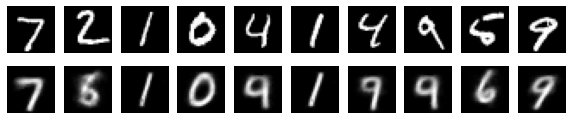

In [56]:
# Set the model to evaluation mode
vae.eval()

# Create empty lists to store the input images and decoded images
input_images = []
decoded_images = []

with torch.no_grad():
    # Iterate over the test dataloader
    for data in test_loader:
        # Get the input data
        img, _ = data
        img = img.to(device)

        # Flatten the input data
        # inputs = inputs.view(inputs.size(0), -1)

        # Forward pass
        recon_batch, _, _ = vae(img)

        # Append the input and decoded images to the lists
        input_images.append(img.detach().cpu().numpy())
        decoded_images.append(recon_batch.detach().cpu().numpy())

# Concatenate the input and decoded images
input_images = np.concatenate(input_images)
decoded_images = np.concatenate(decoded_images)

# Reshape the images
input_images = input_images.reshape(-1, 28, 28)
decoded_images = decoded_images.reshape(-1, 28, 28)

# Plot the input and decoded images
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(10):
    axes[0, i].imshow(input_images[i], cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(decoded_images[i], cmap='gray')
    axes[1, i].axis('off')

plt.show()


### Latent Space Plot

The latent space of the VAE is plotted. The latent space is a 2D space. The latent space shows clustering of the handwritten digits (0-9). Same digits cluster together. Different digits are far apart. Notice the entire distribution forms a Gaussian distribution.

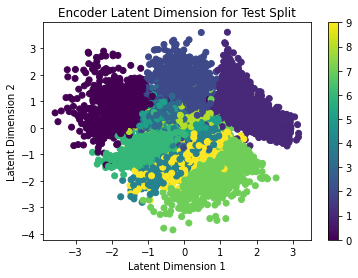

In [57]:
# Set the model to evaluation mode
vae.eval()

# Get the latent dimension for the test split
with torch.no_grad():
    test_latent = []
    for img, _ in test_dataset:
        img = img.unsqueeze(0).to(device)
        latent, _ = vae.encode(img)
        test_latent.append(latent.cpu().numpy())
    test_latent = np.concatenate(test_latent)

# Plot the latent dimension
plt.scatter(test_latent[:, 0], test_latent[:, 1], c=test_dataset.targets.numpy())
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Encoder Latent Dimension for Test Split')
plt.show()


## Digits Plot as a Function of Latent Space

The VAE is able to generate images of handwritten digits (0-9) as a function of the latent space. The latent space is sampled from a Uniform Distribution centered a (0,0). The VAE is able to generate images of handwritten digits.

This plot is the same as the above latent space plot except that the digits are plotted as a function of the latent space. 

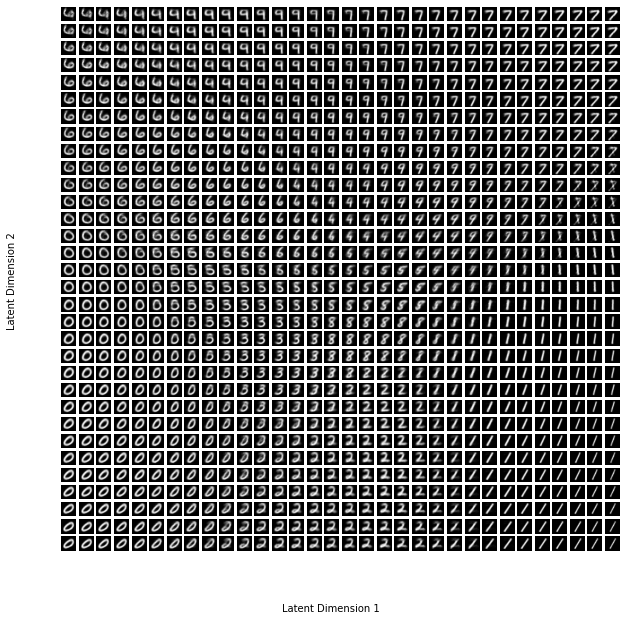

In [58]:
n_dim = 32

latent_dim = torch.FloatTensor(n_dim*n_dim, 2).to(device)
latent_dim[:, 0] = torch.linspace(-2, 2, n_dim).repeat(n_dim)
latent_dim[:, 1] = torch.linspace(-2, 2, n_dim).unsqueeze(1).repeat(1, n_dim).view(-1)
latent_dim = latent_dim.to(device)

# Generate images from the decoder
with torch.no_grad():
    generated_images = vae.decoder(latent_dim)

# Plot the images as a function of latent dim
fig, axs = plt.subplots(n_dim, n_dim, figsize=(10, 10))
for i in range(n_dim):
    for j in range(n_dim):
        axs[i, j].imshow(generated_images[i*n_dim+j].cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')
        
fig.set_label('Generated Images')

fig.text(0.5, 0.04, 'Latent Dimension 1', ha='center')
fig.text(0.05, 0.5, 'Latent Dimension 2', va='center', rotation='vertical')

plt.xlabel('Latent Dimension 1')

plt.show()
